In [9]:
import pandas as pd
import pandas_datareader as web
import yfinance as yf
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import datetime
xgb.__version__

'0.90'

In [10]:
#variables ticker to predict and ticker to compare it to
ticker_pred = "SPY"
ticker_comp_2 = "QQQ"

prediction_feature = "Close"
prediction_feature_2 = "Close"

In [11]:
#PRICE DATA FROM YAHOO FINANCE
data_pred = yf.download(ticker_pred, start="2000-01-01", end="2020-11-06")
data_pred = data_pred.drop(columns=['Adj Close'])

[*********************100%***********************]  1 of 1 completed


In [12]:
#calculate returns
data = data_pred.copy()
data = data / data.shift(1)
data = data.dropna()

In [13]:
data_pred.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2020-10-30,328.279999,329.690002,322.600006,326.540009,120287300
2020-11-02,330.200012,332.359985,327.239990,330.200012,86068300
2020-11-03,333.690002,338.250000,330.290009,336.029999,93294200
2020-11-04,340.859985,347.940002,339.589996,343.540009,126959700
2020-11-05,349.239990,352.190002,348.859985,350.239990,82039700


In [14]:
# add n sequence columns
n_steps = 300
for n in range(1, n_steps + 1):
  data[f"{n}_{prediction_feature}"] = data[prediction_feature].shift(n)
  data[f"{n}_{prediction_feature_2}"] = data[prediction_feature_2].shift(n)
  data[f"{n}_Volume"] = data["Volume"].shift(n)

data = data.dropna()

In [15]:
# outcome
data.loc[data[prediction_feature].shift(-1) > 1, 'Outcome'] = 1
data.loc[data[prediction_feature].shift(-1) <= 1, 'Outcome'] = 0
data = data.dropna()

In [17]:
data.tail()

,Open,High,Low,Close,Volume,1_Close,1_Volume,2_Close,2_Volume,3_Close,3_Volume,4_Close,4_Volume,5_Close,5_Volume,6_Close,6_Volume,7_Close,7_Volume,8_Close,8_Volume,9_Close,9_Volume,10_Close,10_Volume,11_Close,11_Volume,12_Close,12_Volume,13_Close,13_Volume,14_Close,14_Volume,15_Close,15_Volume,16_Close,16_Volume,17_Close,17_Volume,18_Close,18_Volume,19_Close,19_Volume,20_Close,20_Volume,21_Close,21_Volume,22_Close,22_Volume,23_Close,23_Volume,24_Close,24_Volume,25_Close,25_Volume,26_Close,26_Volume,27_Close,27_Volume,28_Close,28_Volume,29_Close,29_Volume,30_Close,30_Volume,Outcome
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-10-29,0.984372,0.985661,0.996811,1.010163,0.712838,0.965821,1.925843,0.996553,0.721460,0.981520,1.861330,1.003395,0.887085,1.005485,0.871401,0.998107,1.058668,1.004006,0.877623,0.984797,0.764516,0.999396,1.482858,0.998764,1.041392,0.993717,0.791186,0.993474,0.911268,1.016088,1.350418,1.008930,1.315767,1.008863,0.793734,1.017407,0.632423,0.985784,1.971621,1.017733,0.511154,0.990506,1.008257,1.006420,0.855721,1.007582,2.020384,0.994554,0.794369,1.016609,0.908754,1.016167,0.926815,1.002665,0.823537,0.976809,1.463750,1.010184,0.639634,0.988870,0.939297,0.984546,1.156841,0.991205,1.114833,0.0
2020-10-30,1.004191,0.988872,0.992341,0.989575,1.327708,1.010163,0.712838,0.965821,1.925843,0.996553,0.721460,0.981520,1.861330,1.003395,0.887085,1.005485,0.871401,0.998107,1.058668,1.004006,0.877623,0.984797,0.764516,0.999396,1.482858,0.998764,1.041392,0.993717,0.791186,0.993474,0.911268,1.016088,1.350418,1.008930,1.315767,1.008863,0.793734,1.017407,0.632423,0.985784,1.971621,1.017733,0.511154,0.990506,1.008257,1.006420,0.855721,1.007582,2.020384,0.994554,0.794369,1.016609,0.908754,1.016167,0.926815,1.002665,0.823537,0.976809,1.463750,1.010184,0.639634,0.988870,0.939297,0.984546,1.156841,1.0
2020-11-02,1.005849,1.008098,1.014383,1.011208,0.715523,0.989575,1.327708,1.010163,0.712838,0.965821,1.925843,0.996553,0.721460,0.981520,1.861330,1.003395,0.887085,1.005485,0.871401,0.998107,1.058668,1.004006,0.877623,0.984797,0.764516,0.999396,1.482858,0.998764,1.041392,0.993717,0.791186,0.993474,0.911268,1.016088,1.350418,1.008930,1.315767,1.008863,0.793734,1.017407,0.632423,0.985784,1.971621,1.017733,0.511154,0.990506,1.008257,1.006420,0.855721,1.007582,2.020384,0.994554,0.794369,1.016609,0.908754,1.016167,0.926815,1.002665,0.823537,0.976809,1.463750,1.010184,0.639634,0.988870,0.939297,1.0
2020-11-03,1.010569,1.017722,1.009320,1.017656,1.083955,1.011208,0.715523,0.989575,1.327708,1.010163,0.712838,0.965821,1.925843,0.996553,0.721460,0.981520,1.861330,1.003395,0.887085,1.005485,0.871401,0.998107,1.058668,1.004006,0.877623,0.984797,0.764516,0.999396,1.482858,0.998764,1.041392,0.993717,0.791186,0.993474,0.911268,1.016088,1.350418,1.008930,1.315767,1.008863,0.793734,1.017407,0.632423,0.985784,1.971621,1.017733,0.511154,0.990506,1.008257,1.006420,0.855721,1.007582,2.020384,0.994554,0.794369,1.016609,0.908754,1.016167,0.926815,1.002665,0.823537,0.976809,1.463750,1.010184,0.639634,1.0
2020-11-04,1.021487,1.028647,1.028157,1.022349,1.360853,1.017656,1.083955,1.011208,0.715523,0.989575,1.327708,1.010163,0.712838,0.965821,1.925843,0.996553,0.721460,0.981520,1.861330,1.003395,0.887085,1.005485,0.871401,0.998107,1.058668,1.004006,0.877623,0.984797,0.764516,0.999396,1.482858,0.998764,1.041392,0.993717,0.791186,0.993474,0.911268,1.016088,1.350418,1.008930,1.315767,1.008863,0.793734,1.017407,0.632423,0.985784,1.971621,1.017733,0.511154,0.990506,1.008257,1.006420,0.855721,1.007582,2.020384,0.994554,0.794369,1.016609,0.908754,1.016167,0.926815,1.002665,0.823537,0.976809,1.463750,1.0


In [18]:
data_model = data#[[prediction_feature, "Volume", "Outcome"]]
data_model = data_model.iloc[:, :]
data_model.columns
ss = pd.DataFrame(data_model.columns)
ss

,0
0,Open
1,High
2,Low
3,Close
4,Volume
...,...
61,29_Close
62,29_Volume
63,30_Close
64,30_Volume


In [19]:
#xgboost test, train, split, fit
#store X and Y data
X = data_model.iloc[:, :-1].astype(float).values
y = data_model.iloc[:, -1].astype(float).values

In [20]:
#splitting the training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

In [21]:
#fitting gboost to train set
from xgboost import XGBClassifier
classifier = XGBClassifier(
    enable_experimental_json_serialization=True,
    n_estimators=300,
    learning_rate=0.02,
    max_depth=4,
    subsample = 0.8,
    colsample_bytree = 1,
    gamma=.1)
classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              enable_experimental_json_serialization=True, gamma=0.1,
              learning_rate=0.02, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [22]:
#predicting the test set absolute results
y_pred = classifier.predict(X_test)
np.array(np.round(y_pred, 3)[:10])

array([1., 1., 1., 1., 1., 1., 0., 1., 1., 0.])

In [23]:
#predicting the probability test set results
y_pred_proba = classifier.predict_proba(X_test)
np.array(np.round(y_pred_proba, 3)[:5])

array([[0.353, 0.647],
       [0.408, 0.592],
       [0.485, 0.515],
       [0.481, 0.519],
       [0.398, 0.602]], dtype=float32)

In [24]:
#compare only high probability items to result and determine best threshold
for threshold in range(51, 99, 1):
    counts = 0
    thresh_counts = 0
    correct = 0
    y_test_hp = []
    y_pred_hp = []
    for i in y_pred_proba:
        actual_result = y_test[counts]
        countj = 0
        for j in i:
            if j >= threshold / 100:
                y_test_hp.append(actual_result)
                y_pred_hp.append(countj)
                thresh_counts += 1
                if countj == actual_result:
                    correct += 1
                    # print(j, countj, actual_result)
            countj +=1
        counts += 1
    
    if correct > 0:
        accuracy_hp = round(correct / thresh_counts, 2)
        winning_count = round(correct * accuracy_hp, 0)
        # print (correct, thresh_counts)
        print(f"Accuracy HP: {accuracy_hp * 100}%, Winning Count: {winning_count}, Threshold: {threshold}")


Accuracy HP: 52.0%, Winning Count: 125.0, Threshold: 51
Accuracy HP: 51.0%, Winning Count: 103.0, Threshold: 52
Accuracy HP: 52.0%, Winning Count: 97.0, Threshold: 53
Accuracy HP: 52.0%, Winning Count: 84.0, Threshold: 54
Accuracy HP: 53.0%, Winning Count: 74.0, Threshold: 55
Accuracy HP: 53.0%, Winning Count: 61.0, Threshold: 56
Accuracy HP: 52.0%, Winning Count: 46.0, Threshold: 57
Accuracy HP: 53.0%, Winning Count: 39.0, Threshold: 58
Accuracy HP: 55.00000000000001%, Winning Count: 32.0, Threshold: 59
Accuracy HP: 55.00000000000001%, Winning Count: 27.0, Threshold: 60
Accuracy HP: 56.99999999999999%, Winning Count: 22.0, Threshold: 61
Accuracy HP: 63.0%, Winning Count: 21.0, Threshold: 62
Accuracy HP: 61.0%, Winning Count: 16.0, Threshold: 63
Accuracy HP: 64.0%, Winning Count: 15.0, Threshold: 64
Accuracy HP: 60.0%, Winning Count: 9.0, Threshold: 65
Accuracy HP: 59.0%, Winning Count: 6.0, Threshold: 66
Accuracy HP: 55.00000000000001%, Winning Count: 3.0, Threshold: 67
Accuracy HP: 8

In [25]:
#making the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 55, 187],
       [ 59, 221]])

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
acc_std = accuracies.std()
acc_mean = accuracies.mean()
print("Accuracy non-Kf: %.2f%% (%.2f%%)" % (acc_mean*100, acc_std*100))

In [ ]:
#get real model results for average
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=False)
results = cross_val_score(classifier, X, y, cv=kfold)
print("Real Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
# the 0 means acc on down days and 1 is acc on up days
from sklearn.metrics import classification_report
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

         0.0       0.76      0.68      0.72       234
         1.0       0.74      0.81      0.77       261

    accuracy                           0.75       495
   macro avg       0.75      0.74      0.74       495
weighted avg       0.75      0.75      0.75       495



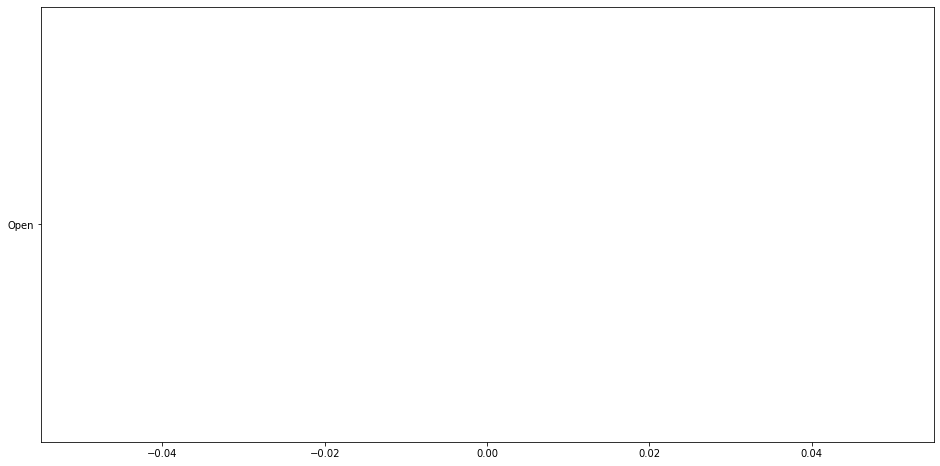

In [ ]:
preds = pd.DataFrame()
preds["Y_Pred"] = y_pred
preds["Y_Actual"] = y_test
plt.figure(figsize=(16,8))
plt.plot(prediction_feature)
plt.show()

In [ ]:
preds.to_csv("preds_test.csv")

In [ ]:
#feature importance
from xgboost import plot_importance
plot_importance(classifier)
plt.show()

In [ ]:
from xgboost import plot_tree
xgb.plot_tree(classifier, num_trees=2)
fig = plt.gcf()
fig.set_size_inches(40, 40)

In [ ]:
# save model to file
classifier.save_model("xgb_price.model.py")